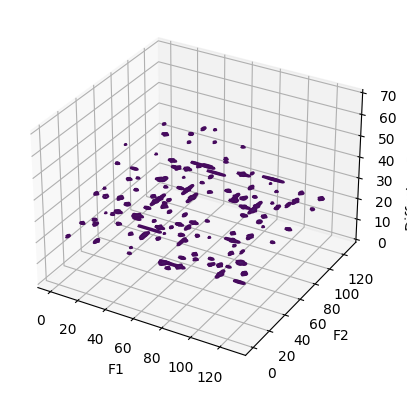

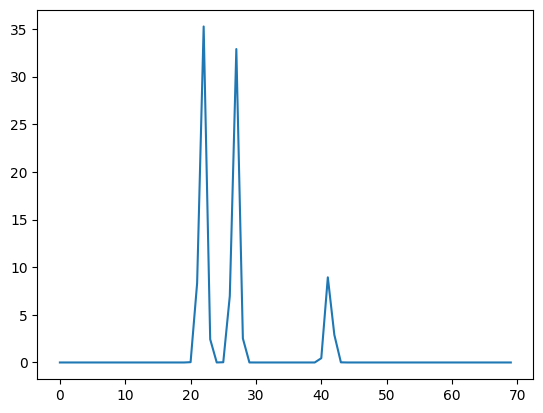

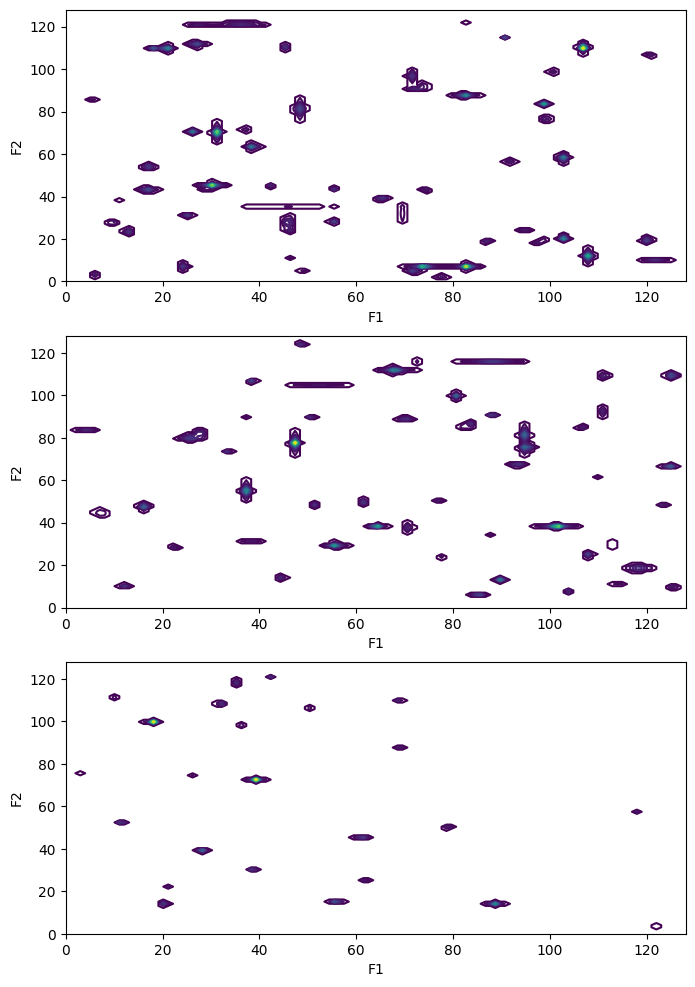

<Figure size 640x480 with 0 Axes>

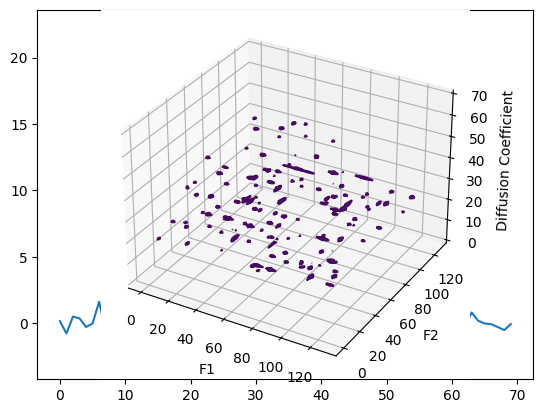

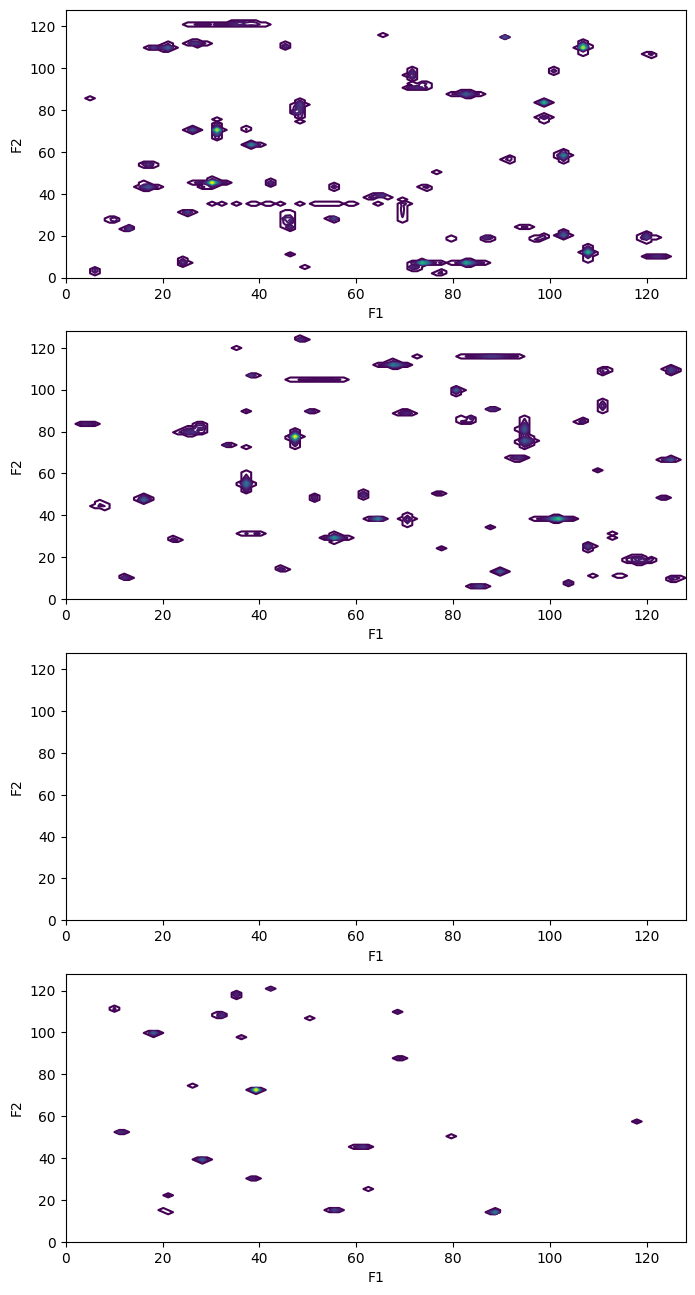

In [2]:
from dataset import gen_3D_DOSY
import matplotlib.pyplot as plt
from config import parse_args
import torch
import numpy as np
from scipy.signal import find_peaks
from model import SimpleModel
# 解析参数
args = parse_args()
device = 'cpu'
# 初始化数据集和模型
dataset = gen_3D_DOSY(args)
model = SimpleModel(args.signal_dim, args.label_size).to(device)
model.load_state_dict(torch.load('result/best_model.pth'))  # 加载最佳模型权重
model.eval()  # 切换到评估模式

# 生成测试数据
S, label, Cif = dataset.__gen_signal__(0)  # 这里可以替换为适当的测试样本索引
S_tensor = torch.tensor(S, dtype=torch.float32).to(device)

# 进行预测
with torch.no_grad():
    outputs = model(S_tensor.unsqueeze(0))
    predicted_label = outputs.squeeze(0).cpu().numpy()  # 将预测结果转换为 NumPy 数组

fig = plt.figure(1)
result = label * Cif.sum(0, keepdims=True)/3
result = result.transpose(1, 2, 0)
frequency1 = np.linspace(0, args.Num_dim2, args.Num_dim2)  # 第一个频率维度
frequency2 = np.linspace(0, args.Num_dim1, args.Num_dim1)  # 第二个频率维度
diffusion_coefficient = np.linspace(0, args.label_size, args.label_size)  # 扩散系数维度

# 创建一个三维网格
F1, F2, D = np.meshgrid(frequency1, frequency2, diffusion_coefficient, indexing='ij')
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(0, 70)
# 对前两个维度求和
summed_result = np.sum(result, axis=(0, 1))
fig = plt.figure()
plt.plot(summed_result)
# 找到峰值的位置
peaks, _ = find_peaks(summed_result, 1, distance=1)

result[:, :, peaks] += result[:, :, peaks+1] + result[:, :, peaks-1]
result[result < np.max(result, axis=(0, 1), keepdims=True) * 0.02] = 0

for i in peaks:
    # 确保 i 在 valid range 内
    if i < D.shape[2] and i < result.shape[2]:  # 确保不超出范围
        Z = D[:, :, i] + result[:, :, i]
        contour = ax.contour(F1[:, :, i], F2[:, :, i], Z, levels=40, zdir='z', offset=i, cmap='viridis')
        plt.clabel(contour, inline=True, fontsize=8)

ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('Diffusion Coefficient')

fig3, ax3 = plt.subplots(len(peaks), 1, figsize=(8, len(peaks) * 4))

for idx, i in enumerate(peaks):
    Z = result[:, :, i]
    contour = ax3[idx].contour(F1[:, :, i], F2[:, :, i], Z, levels=40)  # 使用 ax3[idx]
    ax3[idx].set_xlabel('F1')  # 设置当前子图的 X 轴标签
    ax3[idx].set_ylabel('F2')  # 设置当前子图的 Y 轴标签


result = predicted_label * Cif.sum(0, keepdims=True)/3
result = result.transpose(1, 2, 0)


summed_result = np.sum(result, axis=(0, 1))
fig = plt.figure()
plt.plot(summed_result)

fig = plt.figure()
peaks, _ = find_peaks(summed_result, 2, distance=1)
# 创建一个三维网格
ax = fig.add_subplot(111, projection='3d')
result[result < np.tile(((np.max(result, axis=2)) * 0.7)[..., np.newaxis], [1, args.label_size])] = 0
result[:, :, peaks] += result[:, :, peaks+1] + result[:, :, peaks-1]
result[result < np.max(result, axis=(0, 1), keepdims=True) * 0.02] = 0

ax.set_zlim(0, 70)
for i in peaks:
    # 确保 i 在 valid range 内
    if i < D.shape[2] and i < result.shape[2]:  # 确保不超出范围
        Z = D[:, :, i] + result[:, :, i]
        contour = ax.contour(F1[:, :, i], F2[:, :, i], Z, levels=40, zdir='z', offset=i, cmap='viridis')
        plt.clabel(contour, inline=True, fontsize=8)

fig4, ax4 = plt.subplots(len(peaks), 1, figsize=(8, len(peaks) * 4))

for idx, i in enumerate(peaks):
    Z = result[:, :, i]
    contour = ax4[idx].contour(F1[:, :, i], F2[:, :, i], Z, levels=40)  # 使用 ax3[idx]
    ax4[idx].set_xlabel('F1')  # 设置当前子图的 X 轴标签
    ax4[idx].set_ylabel('F2')  # 设置当前子图的 Y 轴标签

ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('Diffusion Coefficient')

plt.show()
